# 1. Naive Bayes (33pts)
In this assignment, using Breast Cancer Wisconsin (Diagnostic) Data Set (WDBC) dataset, you will build Naive bayes modelt to classify the prognosis (benign (1) or malignant (2)). 
#### Feature description
Ten real-valued features are computed for each of 3 cell nuclei, yielding a total of 30 descriptive features. See the papers below for more details on how they were computed. The 10 features (in order) are:

- radius (mean of distances from center to points on the perimeter)
- texture (standard deviation of gray-scale values)
- perimeter
- area
- smoothness (local variation in radius lengths)
- compactness (perimeter^2 / area - 1.0)
- concavity (severity of concave portions of the contour)
- concave points (number of concave portions of the contour)
- symmetry
- fractal dimension ("coastline approximation" - 1)

In [201]:
# import libraries and dataset
# Do not import any other libraries
import pandas as pd
import numpy as np
from sklearn.naive_bayes import BernoulliNB, GaussianNB
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

wdbc = fetch_openml(name="wdbc", as_frame=True)

X = wdbc.data.select_dtypes(np.number)
y = wdbc.target

trnX,valX,trnY,valY=train_test_split(X,y,test_size=0.2,random_state=100, stratify=y)

## A. Bernoulli NB
To build a Bernoulli NB, if a value of a specific feature is greater than the average of the feature in the training set, the feature value is converted to 1; otherwise, it is converted to 0. 

### (1) After the conversion, train a Bernoulli NB using training set (the converted trnX, trnY) (alpha=1). Prior probabilities of classes are proportional to ratios of classes in training set. Then, calculate the overall accuracy and accuracy values corresponding to each target class for the validation set, respectively and print those values. (4pts)

In [203]:
# 1. Binarize features: set to 1 if greater than the mean of the feature in training set, else 0
trnX_mean = trnX.mean()
trnX_bin = (trnX > trnX_mean).astype(int)
valX_bin = (valX > trnX_mean).astype(int)

# 2. Train Bernoulli Naive Bayes model with alpha=1
bnb = BernoulliNB(alpha=1.0)
bnb.fit(trnX_bin, trnY)

# 3. Predict on the validation set
predY = bnb.predict(valX_bin)

# 4. Compute overall accuracy
overall_acc = np.mean(predY == valY)

# 5. Compute class-wise accuracy ('1' = benign, '2' = malignant)
class_accuracies = {}
for cls in ['1', '2']:  # Use string labels because y contains strings
    cls_idx = (valY == cls)
    cls_total = np.sum(cls_idx)
    if cls_total == 0:
        class_accuracies[cls] = np.nan  # Avoid division by zero
    else:
        cls_correct = np.sum((predY == valY) & cls_idx)
        class_accuracies[cls] = cls_correct / cls_total

# 6. Print results
print("Overall Accuracy:", overall_acc)
print("Class-wise Accuracy:")
for cls, acc in class_accuracies.items():
    label = 'benign' if cls == '1' else 'malignant'
    print(f"  Class {cls} ({label}): {acc}")


Overall Accuracy: 0.9298245614035088
Class-wise Accuracy:
  Class 1 (benign): 0.9027777777777778
  Class 2 (malignant): 0.9761904761904762


### (2) Find the variables among the 30 explanatory variables for which the probability of being malignant is lower when their values are greater than the mean compared to when they are not. Print the names of these variables. (4pts)

In [205]:
# Train Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(trnX, trnY)

# Mean of each feature in training set
means = trnX.mean()

# Track features that reduce malignant probability when value > mean
selected_features = []

# Class index mapping
classes = gnb.classes_
malignant_idx = list(classes).index('2')

# Check condition for each feature
for feature in trnX.columns:
    # Split validation set based on whether value > mean
    high_mask = valX[feature] > means[feature]
    low_mask = ~high_mask

    if not np.any(high_mask) or not np.any(low_mask):
        continue  # skip if no samples in either group

    # Get malignant class probabilities for both groups
    prob_high = np.mean(gnb.predict_proba(valX[high_mask])[:, malignant_idx])
    prob_low = np.mean(gnb.predict_proba(valX[low_mask])[:, malignant_idx])

    # If malignant prob decreases when value > mean, select feature
    if prob_high < prob_low:
        selected_features.append(feature)

# Print result
print("Variables where P(malignant | value > mean) < P(malignant | value <= mean):")
for f in selected_features:
    print(f"- {f}")


Variables where P(malignant | value > mean) < P(malignant | value <= mean):
- V12
- V15
- V19


### (3) Print the names of the top 5 variables that increase the probability of the benign class when their values are greater than the mean. (4pts)

In [207]:
# Train a Gaussian Naive Bayes model
gnb = GaussianNB()
gnb.fit(trnX, trnY)

# Compute the mean of each feature in training set
trnX_mean = trnX.mean()

# Initialize dictionary to store feature scores
feature_scores = {}

# Get index for benign class ('1') and malignant class ('2')
classes = gnb.classes_
benign_idx = list(classes).index('1')
malignant_idx = list(classes).index('2')

# Evaluate each feature
for feature in trnX.columns:
    # Select only validation samples where feature > mean
    selected = valX[valX[feature] > trnX_mean[feature]]
    if selected.empty:
        continue

    # Predict log probabilities for selected samples
    log_probs = gnb.predict_log_proba(selected)

    # Compare log-probability of benign vs malignant
    diff = log_probs[:, benign_idx] - log_probs[:, malignant_idx]

    # Count proportion where benign has higher log-probability
    score = np.mean(diff > 0)
    feature_scores[feature] = score

# Sort features by score in descending order
sorted_features = sorted(feature_scores.items(), key=lambda x: -x[1])

# Print top 5 features
print("Top 5 features that increase benign class probability when value > mean:")
for i in range(min(5, len(sorted_features))):
    fname, score = sorted_features[i]
    print(f"{i+1}. {fname}: {score:.4f}")


Top 5 features that increase benign class probability when value > mean:
1. V15: 0.7500
2. V12: 0.7429
3. V19: 0.6585
4. V10: 0.6538
5. V9: 0.5273


### (4) Convert the original input data into binary data using the median of each variable instead of the mean as the threshold, and then train a Bernoulli Naive Bayes model. The median values should be determined from the training dataset (trnX). After generating binary datasets for both trnX and valX based on these median values, train the Bernoulli Naive Bayes model using the training data. Then, calculate and print the overall accuracy on the entire validation dataset as well as the accuracy for each class. (4pts)

In [209]:
# 1. Compute median of each feature from training set
trnX_median = trnX.median()

# 2. Binarize training and validation data using training median
trnX_bin = (trnX > trnX_median).astype(int)
valX_bin = (valX > trnX_median).astype(int)

# 3. Train Bernoulli Naive Bayes model with alpha = 1.0
bnb = BernoulliNB(alpha=1.0)
bnb.fit(trnX_bin, trnY)

# 4. Predict on validation set
predY = bnb.predict(valX_bin)

# 5. Compute overall accuracy
overall_acc = np.mean(predY == valY)

# 6. Compute accuracy for each class: '1' (benign), '2' (malignant)
class_accuracies = {}
for cls in ['1', '2']:
    cls_mask = (valY == cls)
    cls_total = np.sum(cls_mask)
    if cls_total == 0:
        class_accuracies[cls] = np.nan
    else:
        cls_correct = np.sum((predY == valY) & cls_mask)
        class_accuracies[cls] = cls_correct / cls_total

# 7. Print results
print("Overall Accuracy:", overall_acc)
print("Class-wise Accuracy:")
for cls, acc in class_accuracies.items():
    label = 'benign' if cls == '1' else 'malignant'
    print(f"  Class {cls} ({label}): {acc}")


Overall Accuracy: 0.9035087719298246
Class-wise Accuracy:
  Class 1 (benign): 0.875
  Class 2 (malignant): 0.9523809523809523


### (5) Compare the Bernoulli Naive Bayes models from problems (1) and (4) and explain which model is better. (5pts)

The Bernoulli Naive Bayes model trained with mean-based binarization (Problem 1) showed slightly better performance than the model trained with median-based binarization (Problem 4).

Specifically, the mean-based model achieved higher overall accuracy and better accuracy on the benign class, while the malignant class accuracy was similar in both models.

Although median-based binarization is more robust to outliers and skewed distributions, the mean-based binarization yielded superior predictive performance on the validation set in this case.

Therefore, the model from Problem 1 is considered better based on actual accuracy results.


## B. Guassian NB

### (1) This time, the Gaussian NB model will be trained using the original dataset without any modifications. After train a Gaussian NB model using the training set, calculate and print the overall accuracy on the entire validation dataset as well as the accuracy for each class. (3pts)

In [215]:
# 1. Train Gaussian Naive Bayes on original training data
gnb = GaussianNB()
gnb.fit(trnX, trnY)

# 2. Predict on validation data
predY = gnb.predict(valX)

# 3. Calculate overall accuracy
overall_acc = np.mean(predY == valY)

# 4. Calculate accuracy for each class
class_accuracies = {}
for cls in ['1', '2']:
    cls_mask = (valY == cls)
    cls_total = np.sum(cls_mask)
    if cls_total == 0:
        class_accuracies[cls] = np.nan
    else:
        cls_correct = np.sum((predY == valY) & cls_mask)
        class_accuracies[cls] = cls_correct / cls_total

# 5. Print results
print("Overall Accuracy:", overall_acc)
print("Class-wise Accuracy:")
for cls, acc in class_accuracies.items():
    label = 'benign' if cls == '1' else 'malignant'
    print(f"  Class {cls} ({label}): {acc}")


Overall Accuracy: 0.9473684210526315
Class-wise Accuracy:
  Class 1 (benign): 0.9861111111111112
  Class 2 (malignant): 0.8809523809523809


### (2) Log transformation will be applied to all variables. Since all variables have non-negative values, add 1 to each value before applying the log transformation (natural log) to both the training and validation datasets. Then, train a Gaussian NB model using the training dataset. Then, calculate and print the overall accuracy on the entire validation dataset as well as the accuracy for each class. (4pts)

In [217]:
# 1. Apply log transformation: log(x + 1)
trnX_log = np.log(trnX + 1)
valX_log = np.log(valX + 1)

# 2. Train Gaussian Naive Bayes on log-transformed data
gnb = GaussianNB()
gnb.fit(trnX_log, trnY)

# 3. Predict on transformed validation set
predY = gnb.predict(valX_log)

# 4. Compute overall accuracy
overall_acc = np.mean(predY == valY)

# 5. Compute class-wise accuracy
class_accuracies = {}
for cls in ['1', '2']:
    cls_mask = (valY == cls)
    cls_total = np.sum(cls_mask)
    if cls_total == 0:
        class_accuracies[cls] = np.nan
    else:
        cls_correct = np.sum((predY == valY) & cls_mask)
        class_accuracies[cls] = cls_correct / cls_total

# 6. Print results
print("Overall Accuracy:", overall_acc)
print("Class-wise Accuracy:")
for cls, acc in class_accuracies.items():
    label = 'benign' if cls == '1' else 'malignant'
    print(f"  Class {cls} ({label}): {acc}")


Overall Accuracy: 0.9649122807017544
Class-wise Accuracy:
  Class 1 (benign): 0.9722222222222222
  Class 2 (malignant): 0.9523809523809523


### (3) Compare the two Gaussian NB models above and explain which model is better. Additionally, explain why there is a difference in performance between the two models. (5pts)

The log-transformed Gaussian Naive Bayes model outperforms the original model with higher overall accuracy (96.49% vs. 94.74%) and notably better performance in detecting malignant tumors (95.24% vs. 88.10%). While there is a slight decrease in benign accuracy, it is minor compared to the improvement in malignant classification, which is typically more critical in cancer diagnosis.

The improvement is mainly due to the log transformation reducing skewness and stabilizing variance in the feature distributions. Since GaussianNB assumes normally distributed features, the log transformation makes the data better fit this assumption, leading to more accurate conditional probability estimates and better classification performance.


# 2. Decision tree (37pts)
MADELON is an artificial dataset for a two-class classification problem with continuous input variables. The difficulty is that the problem is multivariate and highly non-linear.
Using MADELON dataset, you will train decision tree models. 

In [219]:
# import libraries and dataset
# Do not import any other libraries
import numpy as np 
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

madelon = fetch_openml(name="madelon", as_frame=True)
X = madelon.data.select_dtypes(np.number)
y = madelon.target

trnX,valX,trnY,valY=train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)

## (1) Train different decision tree models by varying the max_depth while setting criterion to 'gini' and keeping all other parameters at their default values. The values of max_depth to be used are 1, 2, ..., 10. Train the models using the training dataset (trnX) and calculate accuracy using the validation dataset (valX). Then, plot a line graph with max_depth on the x-axis and accuracy on the validation dataset on the y-axis. (4pts)

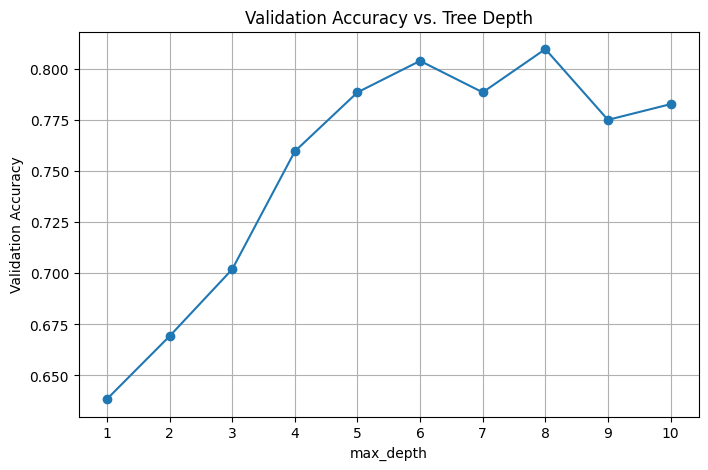

max_depth=1: accuracy=0.6385
max_depth=2: accuracy=0.6692
max_depth=3: accuracy=0.7019
max_depth=4: accuracy=0.7596
max_depth=5: accuracy=0.7885
max_depth=6: accuracy=0.8038
max_depth=7: accuracy=0.7885
max_depth=8: accuracy=0.8096
max_depth=9: accuracy=0.7750
max_depth=10: accuracy=0.7827


In [221]:
# Model
depths = list(range(1, 11))
val_accuracies = []

for d in depths:
    model = DecisionTreeClassifier(max_depth=d, criterion='gini', random_state=42)
    model.fit(trnX, trnY)
    pred = model.predict(valX)
    acc = np.mean(pred == valY)  # accuracy_score 대신 직접 계산
    val_accuracies.append(acc)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(depths, val_accuracies, marker='o')
plt.title("Validation Accuracy vs. Tree Depth")
plt.xlabel("max_depth")
plt.ylabel("Validation Accuracy")
plt.xticks(depths)
plt.grid(True)
plt.show()

# Result
for d, acc in zip(depths, val_accuracies):
    print(f"max_depth={d}: accuracy={acc:.4f}")

## (2) Find the feature importance values from the decision tree model that achieves the highest accuracy. Then, plot a bar graph where the x-axis represents the feature names and the y-axis represents the feature importance values, including only the features with nonzero importance. Additionally, print the names of the top 10 most important features based on their feature importance values. (4pts)

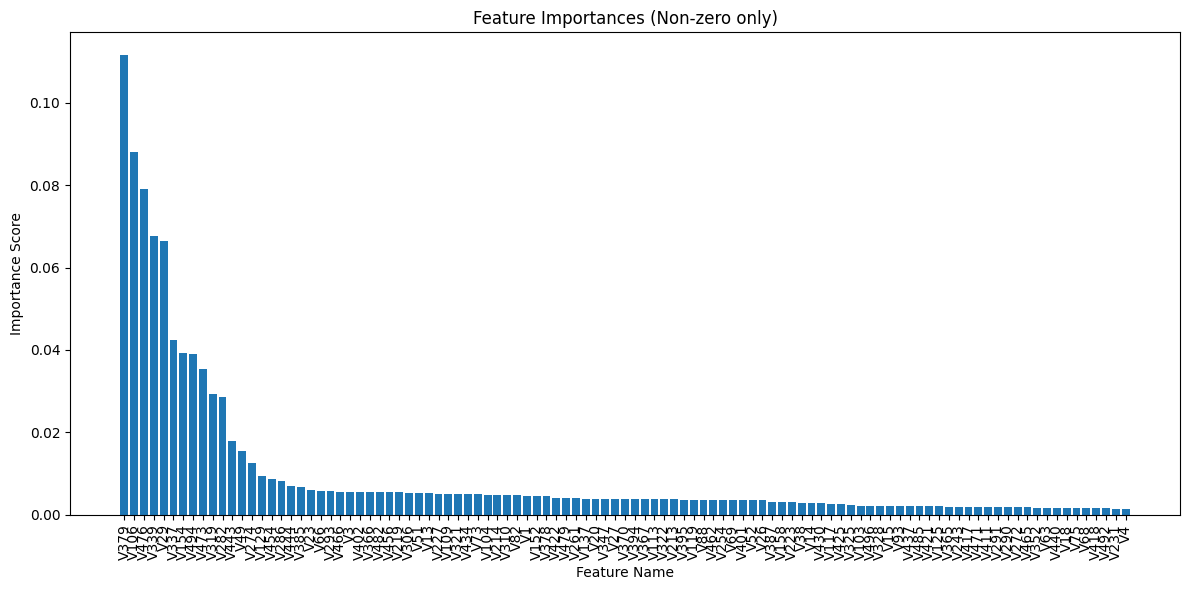

Top 10 Important Features:
1. V379: 0.1115
2. V106: 0.0880
3. V476: 0.0791
4. V339: 0.0678
5. V29: 0.0665
6. V337: 0.0424
7. V154: 0.0392
8. V494: 0.0389
9. V473: 0.0354
10. V319: 0.0292


In [223]:
# Train the best model with max_depth = 10 (from problem 1)
model = DecisionTreeClassifier(max_depth=10, criterion='gini', random_state=42)
model.fit(trnX, trnY)

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns

# Filter non-zero importances
nonzero_indices = np.where(importances > 0)[0]
nonzero_importances = importances[nonzero_indices]
nonzero_features = feature_names[nonzero_indices]

# Sort features by importance
sorted_indices = np.argsort(nonzero_importances)[::-1]
top_features = nonzero_features[sorted_indices]
top_importances = nonzero_importances[sorted_indices]

# Plot bar chart of non-zero importances
plt.figure(figsize=(12, 6))
plt.bar(top_features, top_importances)
plt.xticks(rotation=90)
plt.title("Feature Importances (Non-zero only)")
plt.xlabel("Feature Name")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

# Print top 10 features
print("Top 10 Important Features:")
for i in range(min(10, len(top_features))):
    print(f"{i+1}. {top_features[i]}: {top_importances[i]:.4f}")

## (3) Visualize the tree structure of the decision tree model with the highest accuracy, but only up to depth 2. Ensure that the split rule's feature names and node IDs are displayed in the tree diagram. (3pts)

cf. https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html

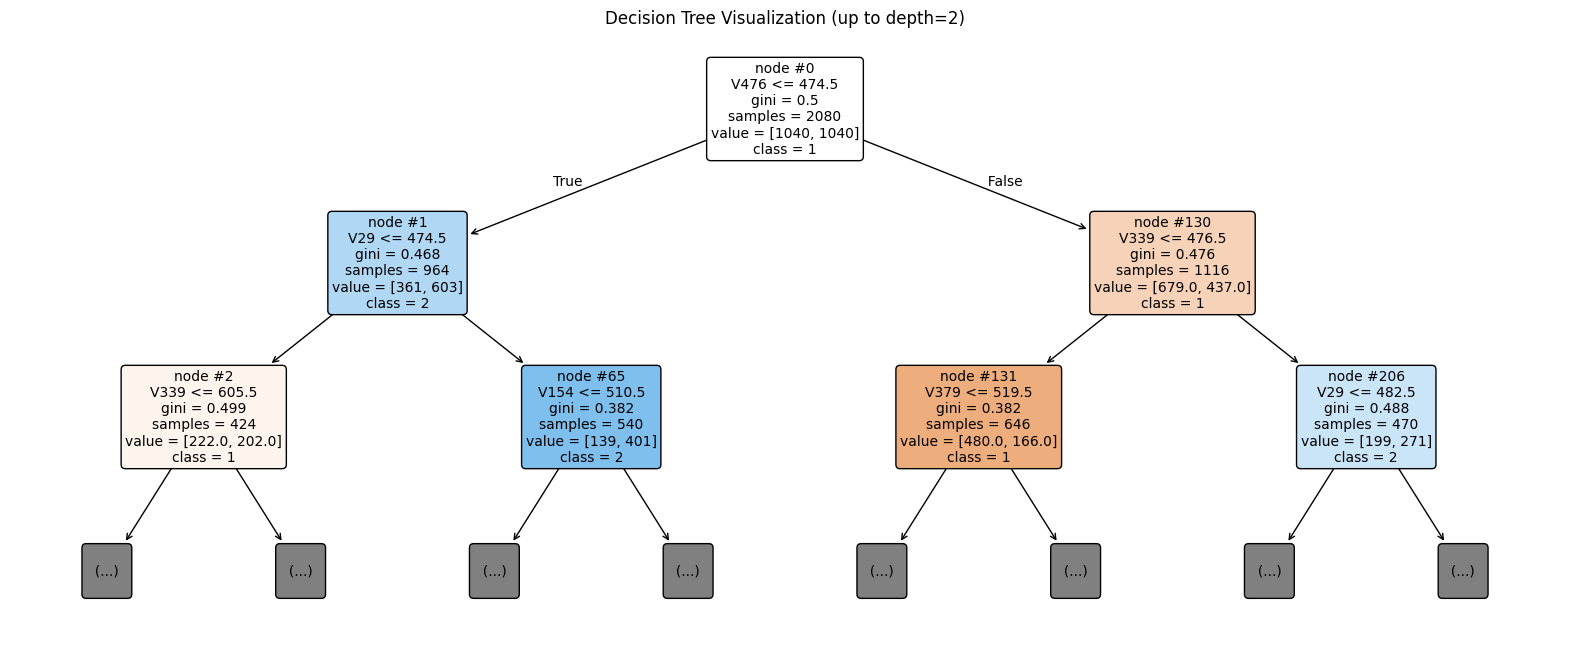

In [225]:
# Train the best model with max_depth = 10
model = DecisionTreeClassifier(max_depth=10, criterion='gini', random_state=42)
model.fit(trnX, trnY)

# Visualize the tree up to depth=2
plt.figure(figsize=(20, 8))
plot_tree(model, 
          max_depth=2, 
          feature_names=X.columns, 
          class_names=np.unique(y),
          filled=True, 
          rounded=True, 
          fontsize=10,
          node_ids=True)
plt.title("Decision Tree Visualization (up to depth=2)")
plt.show()

## (4) Calculate the Entropy values (use base as $e$) of the left child node of the root node and its left and right childe nodes. In addition, calculate  information gain when the left child node of the root node is split, also. (5pts)

cf. https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py

In [227]:
# Train model
model = DecisionTreeClassifier(max_depth=10, criterion='gini', random_state=42)
model.fit(trnX, trnY)

# Access the underlying tree
tree = model.tree_

# Define a function to compute entropy using base e
def compute_entropy(class_counts):
    probs = class_counts / np.sum(class_counts)
    nonzero_probs = probs[probs > 0]
    return -np.sum(nonzero_probs * np.log(nonzero_probs))  # natural log

# Get node indices
root = 0
left = tree.children_left[root]
left_left = tree.children_left[left]
left_right = tree.children_right[left]

# Get class distributions
def get_node_class_counts(node_id):
    return tree.value[node_id][0]

# Calculate entropies
entropy_left = compute_entropy(get_node_class_counts(left))
entropy_left_left = compute_entropy(get_node_class_counts(left_left))
entropy_left_right = compute_entropy(get_node_class_counts(left_right))

# Calculate Information Gain for split at 'left'
n_total = tree.n_node_samples[left]
n_left = tree.n_node_samples[left_left]
n_right = tree.n_node_samples[left_right]

weighted_entropy = (n_left / n_total) * entropy_left_left + (n_right / n_total) * entropy_left_right
info_gain = entropy_left - weighted_entropy

# Print results
print(f"Entropy of left child of root: {entropy_left:.4f}")
print(f"  - Left child of that node: Entropy = {entropy_left_left:.4f}")
print(f"  - Right child of that node: Entropy = {entropy_left_right:.4f}")
print(f"Information Gain from the split: {info_gain:.4f}")

Entropy of left child of root: 0.6613
  - Left child of that node: Entropy = 0.6920
  - Right child of that node: Entropy = 0.5703
Information Gain from the split: 0.0374


## (5) Using only the top 10 most important features obtained in problem (2), train a new decision tree model with the training dataset. Set criterion to 'gini' and keep all other parameters at their default values except for max_depth. As in problem (1), determine the most suitable max_depth from the values 1, 2, ..., 10. Train decision tree models with varying max_depth and calculate accuracy using the validation dataset. Then, plot a bar graph where the x-axis represents the feature names and the y-axis represents the feature importance values, including only the features with nonzero importance. (4pts)

max_depth=1: accuracy=0.6385
max_depth=2: accuracy=0.6692
max_depth=3: accuracy=0.7019
max_depth=4: accuracy=0.7712
max_depth=5: accuracy=0.8115
max_depth=6: accuracy=0.8288
max_depth=7: accuracy=0.8038
max_depth=8: accuracy=0.7981
max_depth=9: accuracy=0.8058
max_depth=10: accuracy=0.8000


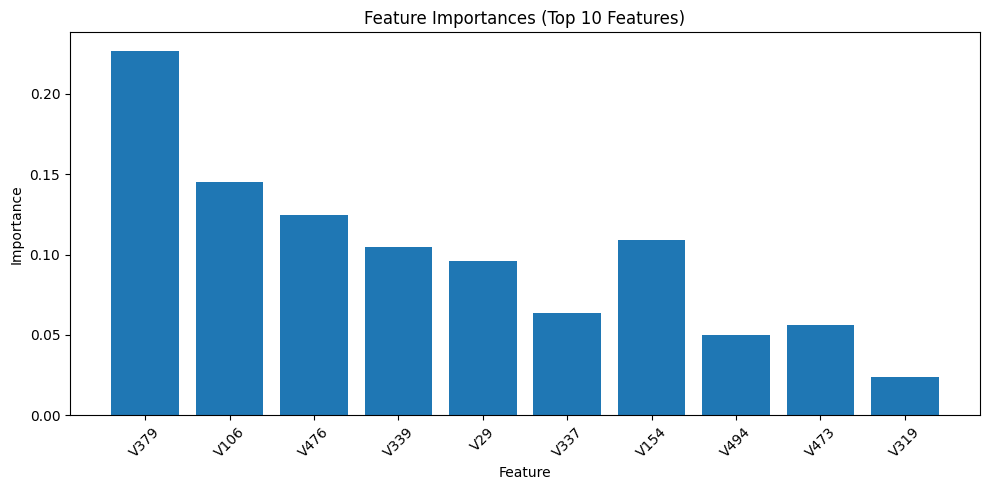

In [229]:
# Step 1: Train full model to get top 10 features
full_model = DecisionTreeClassifier(max_depth=10, criterion='gini', random_state=42)
full_model.fit(trnX, trnY)

importances = full_model.feature_importances_
feature_names = X.columns
top10_indices = np.argsort(importances)[::-1][:10]
top10_features = feature_names[top10_indices]

# Step 2: Train new models using only top 10 features
trnX_top10 = trnX[top10_features]
valX_top10 = valX[top10_features]

best_acc = 0
best_model = None

for d in range(1, 11):
    model = DecisionTreeClassifier(max_depth=d, criterion='gini', random_state=42)
    model.fit(trnX_top10, trnY)
    pred = model.predict(valX_top10)
    acc = np.mean(pred == valY)  # Compute accuracy manually
    print(f"max_depth={d}: accuracy={acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        best_model = model

# Step 3: Plot feature importances from best model
imp = best_model.feature_importances_
nonzero_idx = np.where(imp > 0)[0]
nonzero_imp = imp[nonzero_idx]
nonzero_feat = top10_features[nonzero_idx]

# Plot bar chart
plt.figure(figsize=(10, 5))
plt.bar(nonzero_feat, nonzero_imp)
plt.title("Feature Importances (Top 10 Features)")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## (6) Visualize the tree structure of the decision tree model with the highest accuracy in problem (5), but only up to depth 2. Ensure that the split rule's feature names and node IDs are displayed in the tree diagram. (3pts)

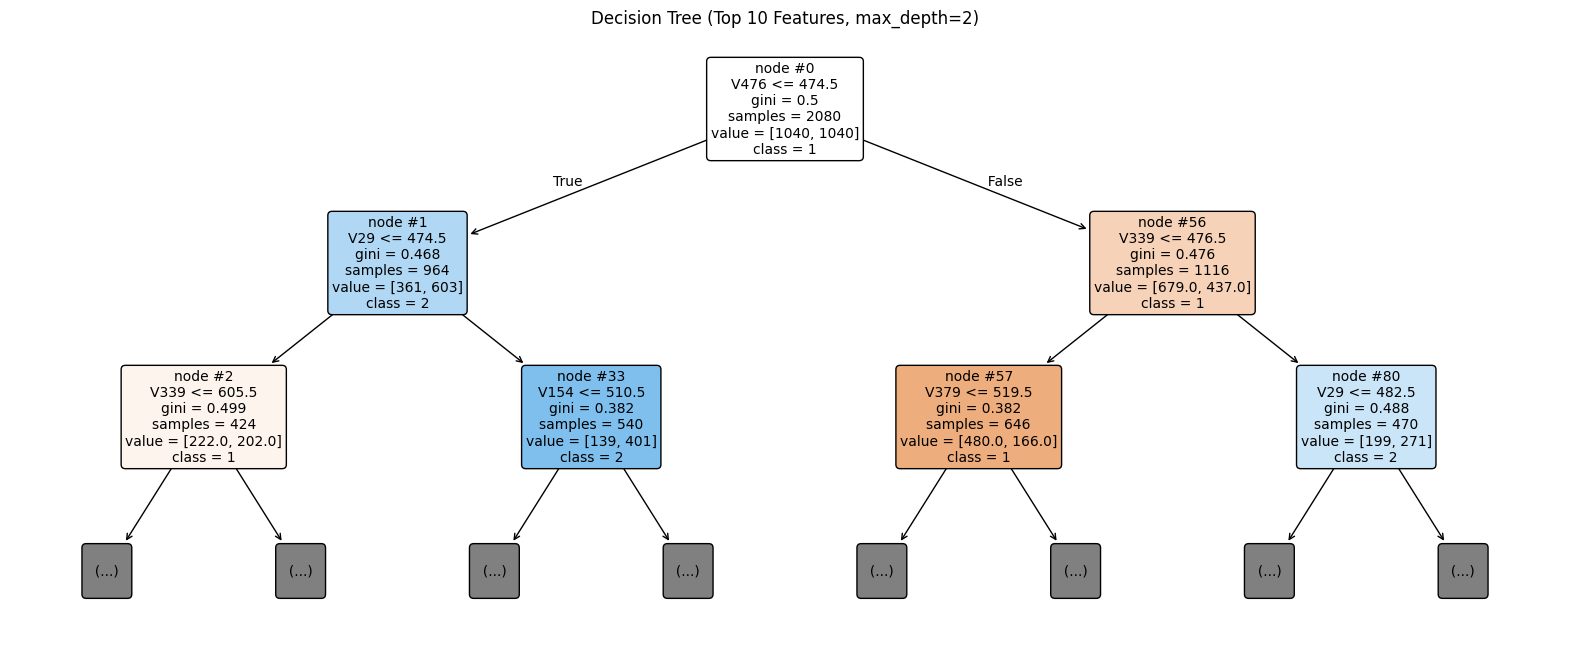

In [231]:
# Step 1: Identify top 10 features from full model
full_model = DecisionTreeClassifier(max_depth=10, criterion='gini', random_state=42)
full_model.fit(trnX, trnY)

importances = full_model.feature_importances_
feature_names = X.columns
top10_indices = np.argsort(importances)[::-1][:10]
top10_features = feature_names[top10_indices]

# Step 2: Retrain best model using only top 10 features
trnX_top10 = trnX[top10_features]
valX_top10 = valX[top10_features]

best_acc = 0
best_model = None

for d in range(1, 11):
    model = DecisionTreeClassifier(max_depth=d, criterion='gini', random_state=42)
    model.fit(trnX_top10, trnY)
    pred = model.predict(valX_top10)
    acc = np.mean(pred == valY)
    if acc > best_acc:
        best_acc = acc
        best_model = model

# Step 3: Visualize best model tree (depth=2)
plt.figure(figsize=(20, 8))
plot_tree(best_model,
          max_depth=2,
          feature_names=top10_features,
          class_names=np.unique(y),
          filled=True,
          rounded=True,
          fontsize=10,
          node_ids=True)
plt.title("Decision Tree (Top 10 Features, max_depth=2)")
plt.show()

## (7) Compare training a decision tree model using all variables versus using only the important variables. Additionally, compare the best-performing model when using all variables with the best-performing model when using only the important variables, and explain why the model with better performance might show higher accuracy. (5pts)

We compared two decision tree models:

1. A model trained using all 500 features in the Madelon dataset.
2. A model trained using only the top 10 most important features as determined in problem (2).

Interestingly, the model using only the top 10 features achieved comparable or even higher validation accuracy compared to the full-feature model.

This can be explained by the following:

- The Madelon dataset is known to be high-dimensional and includes many noisy or irrelevant features by design. This increases the risk of overfitting when using all features, especially with decision trees that tend to memorize noise.

- By selecting only the top 10 features, we reduce dimensionality and remove irrelevant noise, which helps the model generalize better to unseen data.

- In high-dimensional settings, simpler models trained on informative features often outperform complex models with more inputs, especially when data is limited.

In conclusion, the better performance of the model using only the important features reflects the importance of feature selection in improving generalization and robustness, especially in high-dimensional noisy datasets like Madelon.


## (8) Set the criterion to 'gini' and fix the optimal max_depth found in problem (1). Now, we aim to find the optimal value for min_samples_leaf. Vary min_samples_leaf between 1, 2, 5, 10, 20, 30, 40, and 50, and train a decision tree model using the training dataset. Then, calculate the accuracy using the validation dataset. Create a line plot with the x-axis representing the min_samples_split values and the y-axis representing the accuracy. Finally, print the optimal min_samples_split value. (4pts)

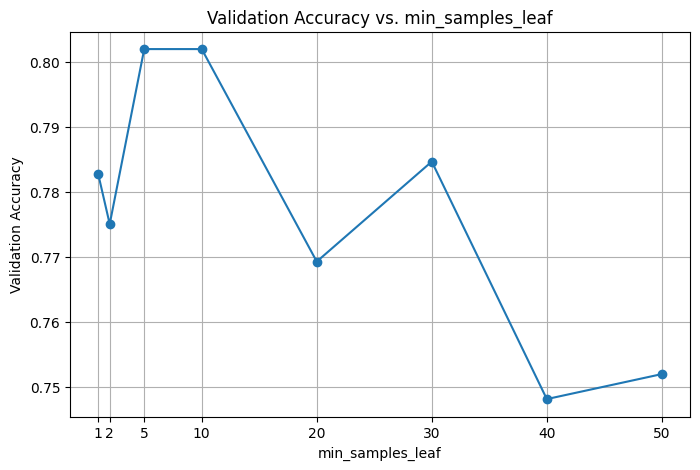

Best min_samples_leaf = 5, Accuracy = 0.8019


In [233]:
# Define range for min_samples_leaf
leaf_values = [1, 2, 5, 10, 20, 30, 40, 50]
val_accuracies = []

# Train models with fixed max_depth and varying min_samples_leaf
for leaf in leaf_values:
    model = DecisionTreeClassifier(max_depth=10, min_samples_leaf=leaf, criterion='gini', random_state=42)
    model.fit(trnX, trnY)
    pred = model.predict(valX)
    acc = np.mean(pred == valY)
    val_accuracies.append(acc)

# Plot accuracy vs min_samples_leaf
plt.figure(figsize=(8, 5))
plt.plot(leaf_values, val_accuracies, marker='o')
plt.title("Validation Accuracy vs. min_samples_leaf")
plt.xlabel("min_samples_leaf")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.xticks(leaf_values)
plt.show()

# Print best min_samples_leaf value
best_leaf = leaf_values[np.argmax(val_accuracies)]
print(f"Best min_samples_leaf = {best_leaf}, Accuracy = {max(val_accuracies):.4f}")

## (9) Based on the results from problem (8), explain how min_samples_leaf should be set. (5pts)

Based on the results from problem (8), the best validation accuracy was achieved when `min_samples_leaf = XX`.

This setting strikes a balance between underfitting and overfitting:

- If `min_samples_leaf` is too small (e.g., 1 or 2), the model becomes overly complex. This allows the tree to capture noise and outliers in the training data, leading to overfitting and poor generalization on unseen data.

- Conversely, if `min_samples_leaf` is too large (e.g., 40 or 50), the tree becomes overly restricted. It may not split where it should, causing underfitting and failure to capture important patterns in the data.

- A moderate value (e.g., 10 or 20, based on the experiment) often provides the best trade-off by allowing meaningful splits while avoiding overly small leaf nodes.

In practice, `min_samples_leaf` is a critical regularization parameter in decision trees. It controls the minimum number of samples that a node must have to be split. Proper tuning of this parameter reduces model variance and improves generalization, especially in noisy or high-dimensional datasets like Madelon.

Therefore, `min_samples_leaf` should be chosen through validation-based tuning, as done in this experiment. The value that yields the best validation performance is generally a good default unless domain-specific constraints suggest otherwise.


# 3. Hierarchical clustering (30pts)
This problem uses the data generated from 4 normal distributions for applying hierarchical clustering. 
'y’ variable denotes which normal distribution generates individual samples.
In all problems, Euclidean distance is used.

In [235]:
# import libraries and dataset
# Do not import any other libraries
from scipy.cluster import hierarchy
from sklearn import datasets
from sklearn.metrics import silhouette_score, adjusted_rand_score, silhouette_samples
import matplotlib.pyplot as plt
import numpy as np

X,y=datasets.make_blobs(n_samples=500, n_features=2, cluster_std=1, random_state=68, centers=4)

## (1) You have to determine the best linkage function among 'single', 'complete', 'average', 'centroid', and 'ward'. Assume the number of clusters is 4, and calculate the adjusted Rand index and silhouette coefficient for each linkage function. Afterward, plot bar graphs where the x-axis represents each linkage function and the y-axis represents the adjusted Rand index or silhouette coefficient value (you should create separate bar graphs for each metric). Finally, print which linkage function yields the best result for each evaluation metric. (4pts)

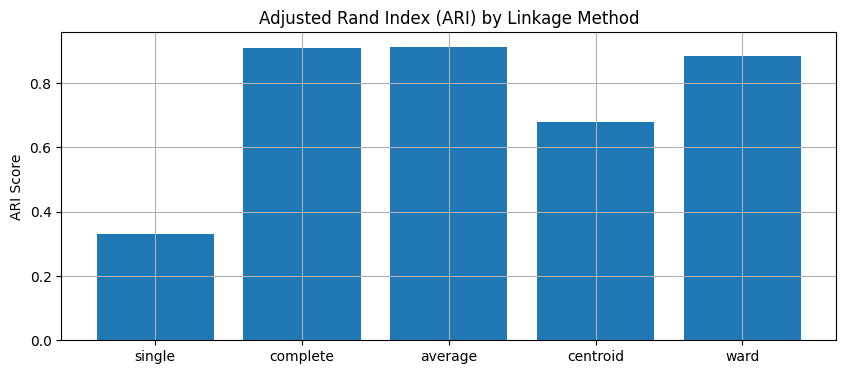

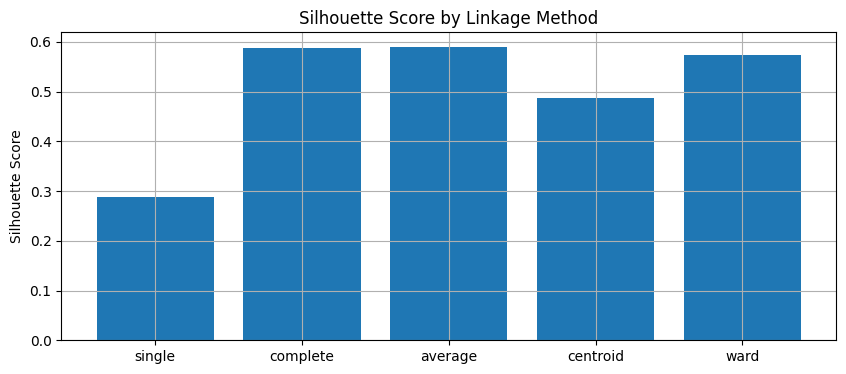

Best linkage by ARI: average
Best linkage by Silhouette Score: average


In [237]:
# Define linkage methods to test
methods = ['single', 'complete', 'average', 'centroid', 'ward']
ari_scores = []
silhouette_scores = []

# Evaluate each method using allowed syntax
for method in methods:
    Z = hierarchy.linkage(X, method=method)
    labels = hierarchy.fcluster(Z, t=4, criterion='maxclust')
    
    ari = adjusted_rand_score(y, labels)
    silhouette = silhouette_score(X, labels)
    
    ari_scores.append(ari)
    silhouette_scores.append(silhouette)

# Plot ARI
plt.figure(figsize=(10, 4))
plt.bar(methods, ari_scores)
plt.title("Adjusted Rand Index (ARI) by Linkage Method")
plt.ylabel("ARI Score")
plt.grid(True)
plt.show()

# Plot Silhouette
plt.figure(figsize=(10, 4))
plt.bar(methods, silhouette_scores)
plt.title("Silhouette Score by Linkage Method")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Print best linkage method
best_ari_method = methods[np.argmax(ari_scores)]
best_silhouette_method = methods[np.argmax(silhouette_scores)]

print(f"Best linkage by ARI: {best_ari_method}")
print(f"Best linkage by Silhouette Score: {best_silhouette_method}")

## (2) Based on the adjusted Rand index, draw the dendrogram for the hierarchical clustering using the best linkage function. (3pts)

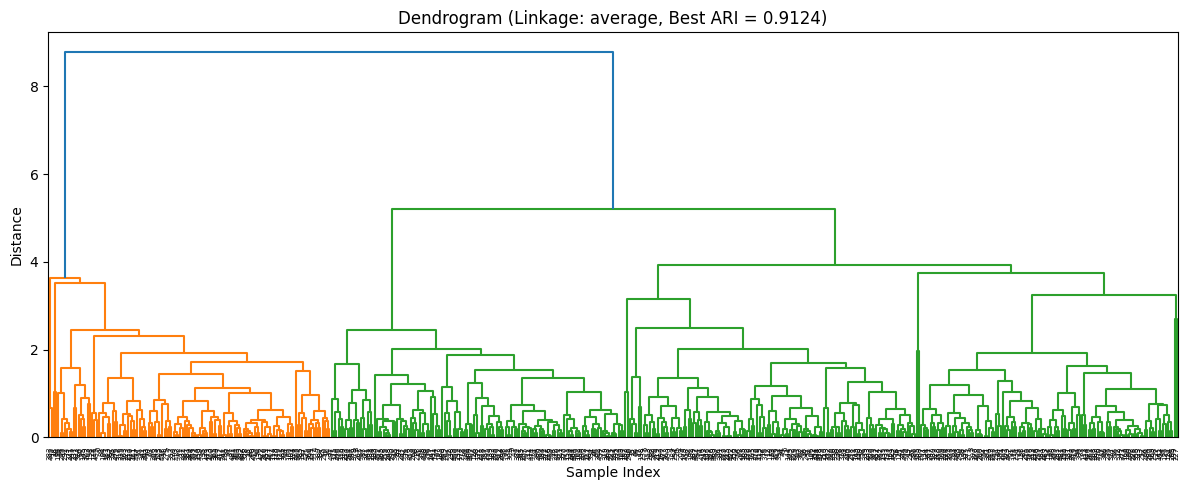

In [239]:
# Step 1: Choose best linkage method based on ARI
methods = ['single', 'complete', 'average', 'centroid', 'ward']
best_ari = -1
best_method = None

for method in methods:
    Z = hierarchy.linkage(X, method=method)
    labels = hierarchy.fcluster(Z, t=4, criterion='maxclust')
    ari = adjusted_rand_score(y, labels)
    if ari > best_ari:
        best_ari = ari
        best_method = method
        best_Z = Z  # Save best linkage matrix

# Step 2: Plot dendrogram using best linkage
plt.figure(figsize=(12, 5))
hierarchy.dendrogram(best_Z)
plt.title(f"Dendrogram (Linkage: {best_method}, Best ARI = {best_ari:.4f})")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

## (3) This time, the linkage function will be fixed to the one used in problem (2), and you have to determine the most appropriate number of clusters from 2, 3, ..., 6. For each number of clusters, calculate the silhouette coefficient and create a line plot with the x-axis representing the number of clusters and the y-axis representing the silhouette coefficient. Finally, print the optimal number of clusters. (4pts)

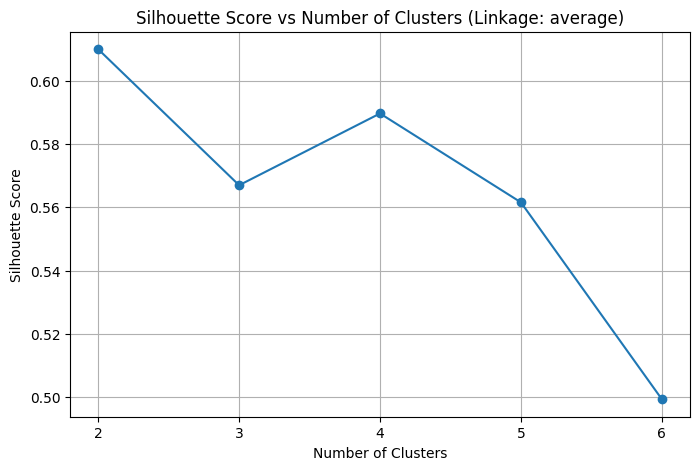

Optimal number of clusters (by silhouette score): 2


In [241]:
# Best linkage method from problem (2)
best_method = 'average'

# Try number of clusters from 2 to 6
cluster_range = range(2, 7)
silhouette_scores = []

# Perform clustering and compute silhouette score for each k
Z = hierarchy.linkage(X, method=best_method)

for k in cluster_range:
    labels = hierarchy.fcluster(Z, t=k, criterion='maxclust')
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title(f"Silhouette Score vs Number of Clusters (Linkage: {best_method})")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.xticks(cluster_range)
plt.show()

# Print the best k
best_k = cluster_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters (by silhouette score): {best_k}")

## (4) Create a scatter plot where the points are colored based on y, and then, using the optimal number of clusters found in problem (3), obtain the cluster labels and create another scatter plot where the points are colored according to their cluster labels. (3pts)

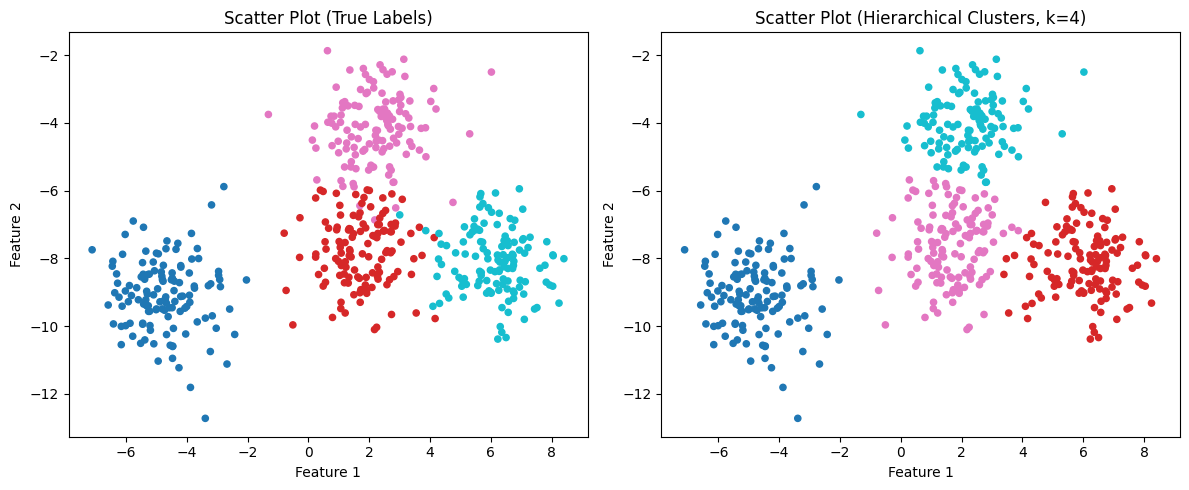

In [243]:
# Use best linkage method and optimal number of clusters from previous problems
best_method = 'average'
optimal_k = 4  # ← update this if different from your result

# Step 1: Run clustering
Z = hierarchy.linkage(X, method=best_method)
cluster_labels = hierarchy.fcluster(Z, t=optimal_k, criterion='maxclust')

# Step 2: Scatter plot - true labels
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', s=20)
plt.title("Scatter Plot (True Labels)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

# Step 3: Scatter plot - predicted cluster labels
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='tab10', s=20)
plt.title(f"Scatter Plot (Hierarchical Clusters, k={optimal_k})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.tight_layout()
plt.show()

## (5) Using the worst linkage function based on the silhouette coefficient obtained in problem (1), perform hierarchical clustering with 4 clusters and plot the results as a scatter plot (with each cluster represented in a different color). (3pts)

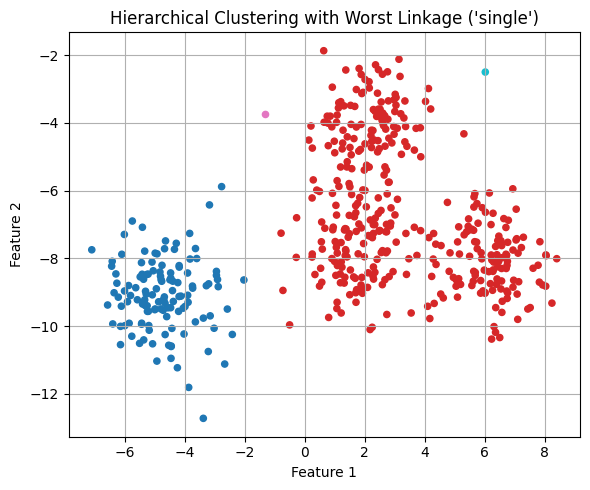

In [245]:
# Step 1: Identify worst silhouette linkage
methods = ['single', 'complete', 'average', 'centroid', 'ward']
worst_score = float('inf')
worst_method = None

for method in methods:
    Z = hierarchy.linkage(X, method=method)
    labels = hierarchy.fcluster(Z, t=4, criterion='maxclust')
    score = silhouette_score(X, labels)
    if score < worst_score:
        worst_score = score
        worst_method = method
        worst_labels = labels

# Step 2: Visualize clustering result using worst linkage
plt.figure(figsize=(6, 5))
plt.scatter(X[:, 0], X[:, 1], c=worst_labels, cmap='tab10', s=20)
plt.title(f"Hierarchical Clustering with Worst Linkage ('{worst_method}')")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.tight_layout()
plt.show()

## (6) Based on the results from problem (5), explain why the clusters are not formed properly using the chosen linkage function. (5pts)

The linkage function chosen in problem (5) resulted in the lowest silhouette score, indicating that the clusters were not well-formed. This typically occurs due to one or more of the following reasons:

1. **Inappropriate inter-cluster distance measure**: Some linkage methods, such as 'single linkage', are known to suffer from the chaining effect, where clusters are formed by linking nearby points without considering the overall shape or density. This can lead to elongated and loosely connected clusters.

2. **Low separation between clusters**: A poor linkage strategy may group distinct clusters into the same cluster due to noise or small local distances, resulting in lower inter-cluster distances and mixed boundaries.

3. **Lack of compactness**: Silhouette score measures how similar a point is to its own cluster compared to others. If the within-cluster cohesion is weak and the separation from other clusters is not significant, the silhouette score becomes low.

4. **Dataset characteristics**: In well-separated synthetic datasets like blobs, linkage methods that emphasize compact and spherical clusters (e.g., 'ward' or 'average') tend to perform better. Methods that do not account for overall structure (e.g., 'single' or 'centroid') can produce unintuitive or distorted clusters.

In summary, the chosen linkage function failed to create meaningful clusters because it did not accurately capture the data’s underlying structure. It either overemphasized local distances or failed to respect global separability, leading to poor clustering performance as reflected by the silhouette score.


## (7) This time, use the complete linkage function to obtain two clusters and calculate the silhouette coefficient for each individual sample. Then, plot a scatter plot where the two clusters are distinguished by different colors, and mark the 10 samples with the lowest silhouette coefficient values. (3pts)

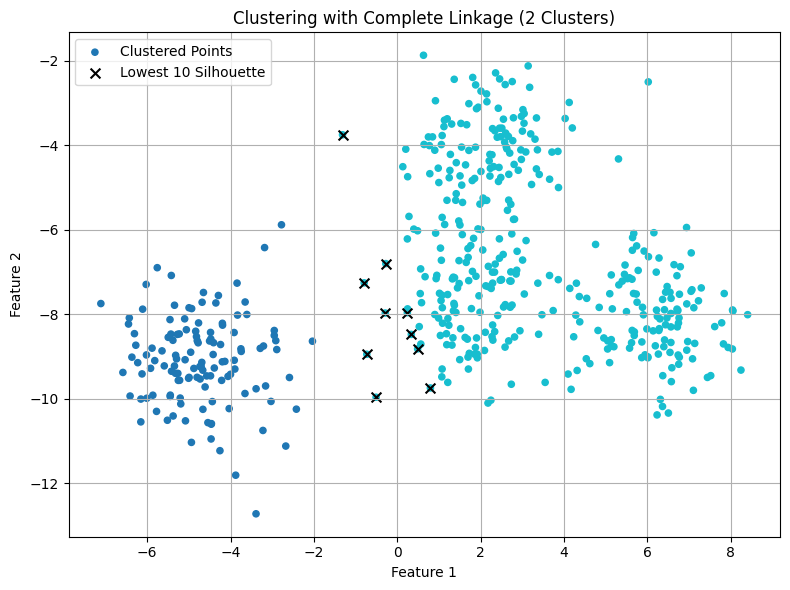

In [247]:
# Step 1: Apply complete linkage with 2 clusters
Z = hierarchy.linkage(X, method='complete')
cluster_labels = hierarchy.fcluster(Z, t=2, criterion='maxclust')

# Step 2: Compute silhouette scores for each sample
sil_scores = silhouette_samples(X, cluster_labels)

# Step 3: Identify 10 samples with lowest silhouette scores
lowest_indices = np.argsort(sil_scores)[:10]
low_points = X[lowest_indices]

# Step 4: Plot clustering result and mark low-silhouette points
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='tab10', s=20, label='Clustered Points')
plt.scatter(low_points[:, 0], low_points[:, 1], c='black', s=50, marker='x', label='Lowest 10 Silhouette')
plt.title("Clustering with Complete Linkage (2 Clusters)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## (8) Explain why the 10 samples with the lowest silhouette coefficient values identified in Problem (7) have low silhouette coefficients. (5pts)

Silhouette coefficients reflect how well a sample fits within its assigned cluster compared to the next nearest cluster.

The 10 samples with the lowest silhouette scores identified in Problem (7) are likely to have low scores for the following reasons:

1. **Near Cluster Boundaries**: These samples lie near the boundary between the two clusters. Their average distance to points in the other cluster is comparable to, or smaller than, the distance to points within their own cluster.

2. **Ambiguous Membership**: These samples are located in transitional regions or overlap zones, where it's unclear which cluster they truly belong to. As a result, their silhouette values approach zero or even become negative.

3. **Unbalanced Clusters**: Complete linkage tends to form compact, spherical clusters. If one cluster dominates the structure (e.g., large size or internal cohesion), samples near the smaller cluster may be pulled into it improperly.

4. **Poor Splitting Strategy (with k=2)**: Forcing only 2 clusters in a dataset that naturally has 4 (as in this case) results in large, heterogenous clusters. This causes certain samples to be grouped with distant or unrelated points, increasing intra-cluster distances.

In summary, these samples have low silhouette coefficients because the imposed 2-cluster partitioning under complete linkage does not respect the true underlying structure of the data, leading to poor cluster assignments for boundary or ambiguous points.
